# Using SigOpt's XGBoost Integration for Fraud Classification

SigOpt's XGBoost integration does more than provide a streamlined SigOpt API for your XGBoost modeling. Read on to learn how the XGBoost integration helps find better performing models faster and simpler than ever before.

This walkthrough will provide an end-to-end example of utilizing the SigOpt XGBoost integration for a classification machine learning problem. For more information, please see our [XGBoost integration blog post announcement](https://sigopt.com/blog/live-now-new-xgboost-integration/), or the XGBoost integration [docs](https://docs.sigopt.com/xgboost/installation), including a tutorial on how to set up and start using SigOpt's XGBoost integration. We recommend that before you dive into this tutorial, [sign up](https://sigopt.com/signup) for a free SigOpt account so you can easily follow along and run the code yourself. 

This blog is available as a Jupyter notebook or via Google Colab for a more interactive experience.

## SigOpt's XGBoost Integration
[XGBoost](https://xgboost.readthedocs.io/en/stable/index.html) is a popular machine learning framework for gradient-boosted trees known for its flexibility, portability, hardware optimizations, efficiency at scale, and general effectiveness for a wide variety of machine learning problems. We at SigOpt have made significant improvements to integrate [XGBoost's learning API](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training) into SigOpt's Python API. 

Additionally, we have devoted significant research and development efforts to enhance SigOpt's efficiency and optimization for XGBoost. This includes model-aware optimization on top of SigOpt's standard hyperparameter optimization, utilizing metalearning and multi-fidelity optimization tailored for XGBoost. Using a variety of datasets, training parameters, and workloads to inform the Bayesian Optimization for XGBoost under the hood, this integration enables the SigOpt optimizer to automatically select the XGBoost hyperparameters and begins its search in hyperparameter value ranges most likely to improve the model's performance, optimizing in an informed fashion with no additional work required from the user. 

In internal testing with a variety of public datasets from small to large, models optimized through the XGBoost integration on average optimized 33% faster than the same XGBoost architectures optimized through vanilla SigOpt without loss of performance. These novel approaches also allow for simpler optimization without an in-depth understanding of XGBoost's 25+ hyperparameters and hyperparameter ranges.

To run this code yourself, you'll need the following:
* a SigOpt account (sign up free [here](https://app.sigopt.com/signup) with an email address)
* a Kaggle account to access the data
* the necessary packages installed in a Python 3 environment where you will run this code from

## Import Packages and Configure SigOpt API

First, ensure you have the SigOpt XGBoost integration installed. If you do not, uncomment the below code to install it.

In [11]:
#%pip install sigopt[xgboost] #this will install numpy and xgboost as dependencies
import sigopt.xgboost

The following will configure your SigOpt API connection from a .ipynb file. Your API token can be found [here](https://app.sigopt.com/tokens/info).

In [1]:
%load_ext sigopt
%sigopt config

SigOpt API token (find at https://app.sigopt.com/tokens/info): ········
SigOpt API token (find at https://app.sigopt.com/tokens/info): ········
Log Collection
	This will capture and upload the standard output and standard error of your
	Runs from the CLI and notebook cells so that you can view them on the SigOpt dashboard.
Enable log collection [y/N]: y
Notebook Cell Tracking
	This will record and upload the content of your notebook cells so that you can view them
	on the SigOpt dashboard.
Enable cell tracking [y/N]: y


Alternatively, and if you are not using an .ipynb file to run this code, uncomment the following code and set the environment variables with your SigOpt API token in order to connect to SigOpt.

In [3]:
#import os
#os.environ["SIGOPT_API_TOKEN"] = # PASTE API TOKEN FROM https://app.sigopt.com/tokens/info
#os.environ["SIGOPT_PROJECT"] = "my-xgb-integration-class-project"

We'll import all other needed packages. If you do not have any of the libraries installed, you can uncomment the following to install the required packages.

In [2]:
#%pip install -r requirements.txt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import xgboost as xgb
import opendatasets as od

random_no = 5

/Users/tskelton/demo/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Prepare Data

Our goal is to create and tune an XGBoost model using SigOpt to classify fraudulent online transactions. Our datasets come from the IEEE Computational Intelligence Society (IEEE-CIS)'s [Kaggle competition](https://www.kaggle.com/competitions/ieee-fraud-detection/overview) from 2019, with data provided by Vesta, an e-commerce company. Let's download this data from Kaggle and take a look at it.

The following code block will download the competition's data .csv files into a new folder in the same directory as this notebook using the open source library [opendatasets](https://github.com/JovianML/opendatasets). You will need to provide your Kaggle username and API token, which can be found by accessing your Kaggle account page and clicking "Create new API Token." This will download a .json file which contains both your username and API token. If you receive an error message, ensure you have also accepted the IEEE-CIS Fraud Detection Kaggle competition rules on the competition data page [here](https://www.kaggle.com/competitions/ieee-fraud-detection/data) while logged in to your Kaggle account.

Alternatively, you can manually download the files from the competition's [data page](https://www.kaggle.com/competitions/ieee-fraud-detection/data) into a folder called "IEEE-fraud-detection" within the same directory as this notebook.

In [3]:
od.download("https://www.kaggle.com/competitions/ieee-fraud-detection/data")

Skipping, found downloaded files in "./ieee-fraud-detection" (use force=True to force download)


We have two train .csv files to examine. Let's take a look at `train_transaction` first.

In [4]:
train_transaction = pd.read_csv("./ieee-fraud-detection/train_transaction.csv")
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This dataset includes a row for each individual transaction, and features which including identifiers, the transaction amount, product category, payment info, and hundreds more features, some of which are missing (NaN) for some data points. We will use these features to train our XGBoost model to learn to predict the `isFraud` column, which specifies whether or not the transaction was fraudulent.

We also have a `train_identity` data source. Let's take a look at that as well.

In [5]:
train_identity = pd.read_csv("./ieee-fraud-detection/train_identity.csv")
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In this dataset, each row corresponds to a transaction and contains information on the buyer. This includes device type and info that was used to make the online transaction, as well as anonymized identifier features.

Let's merge these two datasets so we have all features in one place.

In [6]:
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")
train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In total, our data is a healthy size with nearly 600K rows and over 400 features.

We'll also need to convert the non-numerical data into data our XGBoost model can understand. Let's utilize Scikit-Learn's `LabelEncoder` to convert the text data that into numerical categories.

In [7]:
for col in train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    col_vals = list(train[col].astype(str).values)
    le.fit(col_vals)
    train[col] = le.transform(col_vals)

In the real world, we might perform feature engineering or other data processing techniques to further improve performance. However, for simplicity, we don’t make further changes to our data.

Now that we have our data ready, we'll split the data into a training, validation, and test set. We create a test set with 20% of the data, a validation set with 20% of the data, and use the remaining 60% of the data to train our model.

In [8]:
X = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
y = train['isFraud']

#split data into a test and validation set of 20% of full data
(X_fulltrain, X_test, y_fulltrain, y_test) = train_test_split(X, y, test_size=0.2, random_state=random_no)
(X_train, X_val, y_train, y_val) = train_test_split(X_fulltrain, y_fulltrain, test_size=0.25, random_state=random_no)

dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
dval = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)
dtest = xgb.DMatrix(data=X_test, label=y_test, feature_names=X_test.columns)

As we might expect, most of the data we have is of transactions that are not fraudulent. To correct for imbalance between classes in the underlying data, we calculate the ratio of negative to positive examples. We can provide this to our XGBoost model to weigh the minority class examples greater than the majority class examples. This will hopefully improve our model's performance on fraudulent transactions - despite seeing less examples of this class.

In [9]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
pos_weight

27.34592

## Train Baseline Model

First we'll create and train a baseline XGBoost model with the default hyperparameter values as a simple point of comparison. Although we won't be tuning this model's hyperparameters, we can still use SigOpt for checkpointing, logging, and analyzing the results on SigOpt's web dashboard. Utilizing the `sigopt.xgboost.run` API is very similar to using `xgboost.train`.

In the `sigopt.xgboost.run` call we provide the parameters, the DMatrix with training data, the number of boosting rounds (which we'll set to a modest amount), and the run options. For the simple baseline we won't perform any hyperparameter tuning and use the XGBoost library default values. `sigopt.xgboost.run()` returns an XGBRun object, which we can use to retrieve the trained XGBoost Booster model itself with `.model` and the SigOpt RunContext object with `.run`. 

This code may take a few minutes to run (~10 minutes on a 4 core i5).

In [24]:
%%time
baseline_params = { 'scale_pos_weight':pos_weight, 'objective':'binary:logistic' }
baseline_run_options = { 'name':'Baseline XGBoost Fraud Classifier' }
baseline = sigopt.xgboost.run(baseline_params,
                             dtrain,
                             num_boost_round=200,
                             run_options=baseline_run_options)
baseline_model = baseline.model
print(f"View run at https://app.sigopt.com/run/{baseline.run.id}")

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320431
View run at https://app.sigopt.com/run/320431
CPU times: user 59min 41s, sys: 20.7 s, total: 1h 2s
Wall time: 8min 45s


SigOpt prints the log loss for each round of boosting, which helps us monitor our model's training. If we click the hyperlink printed above, the SigOpt run dashboard provides us with more detailed info on the run's results. Let's take a look:

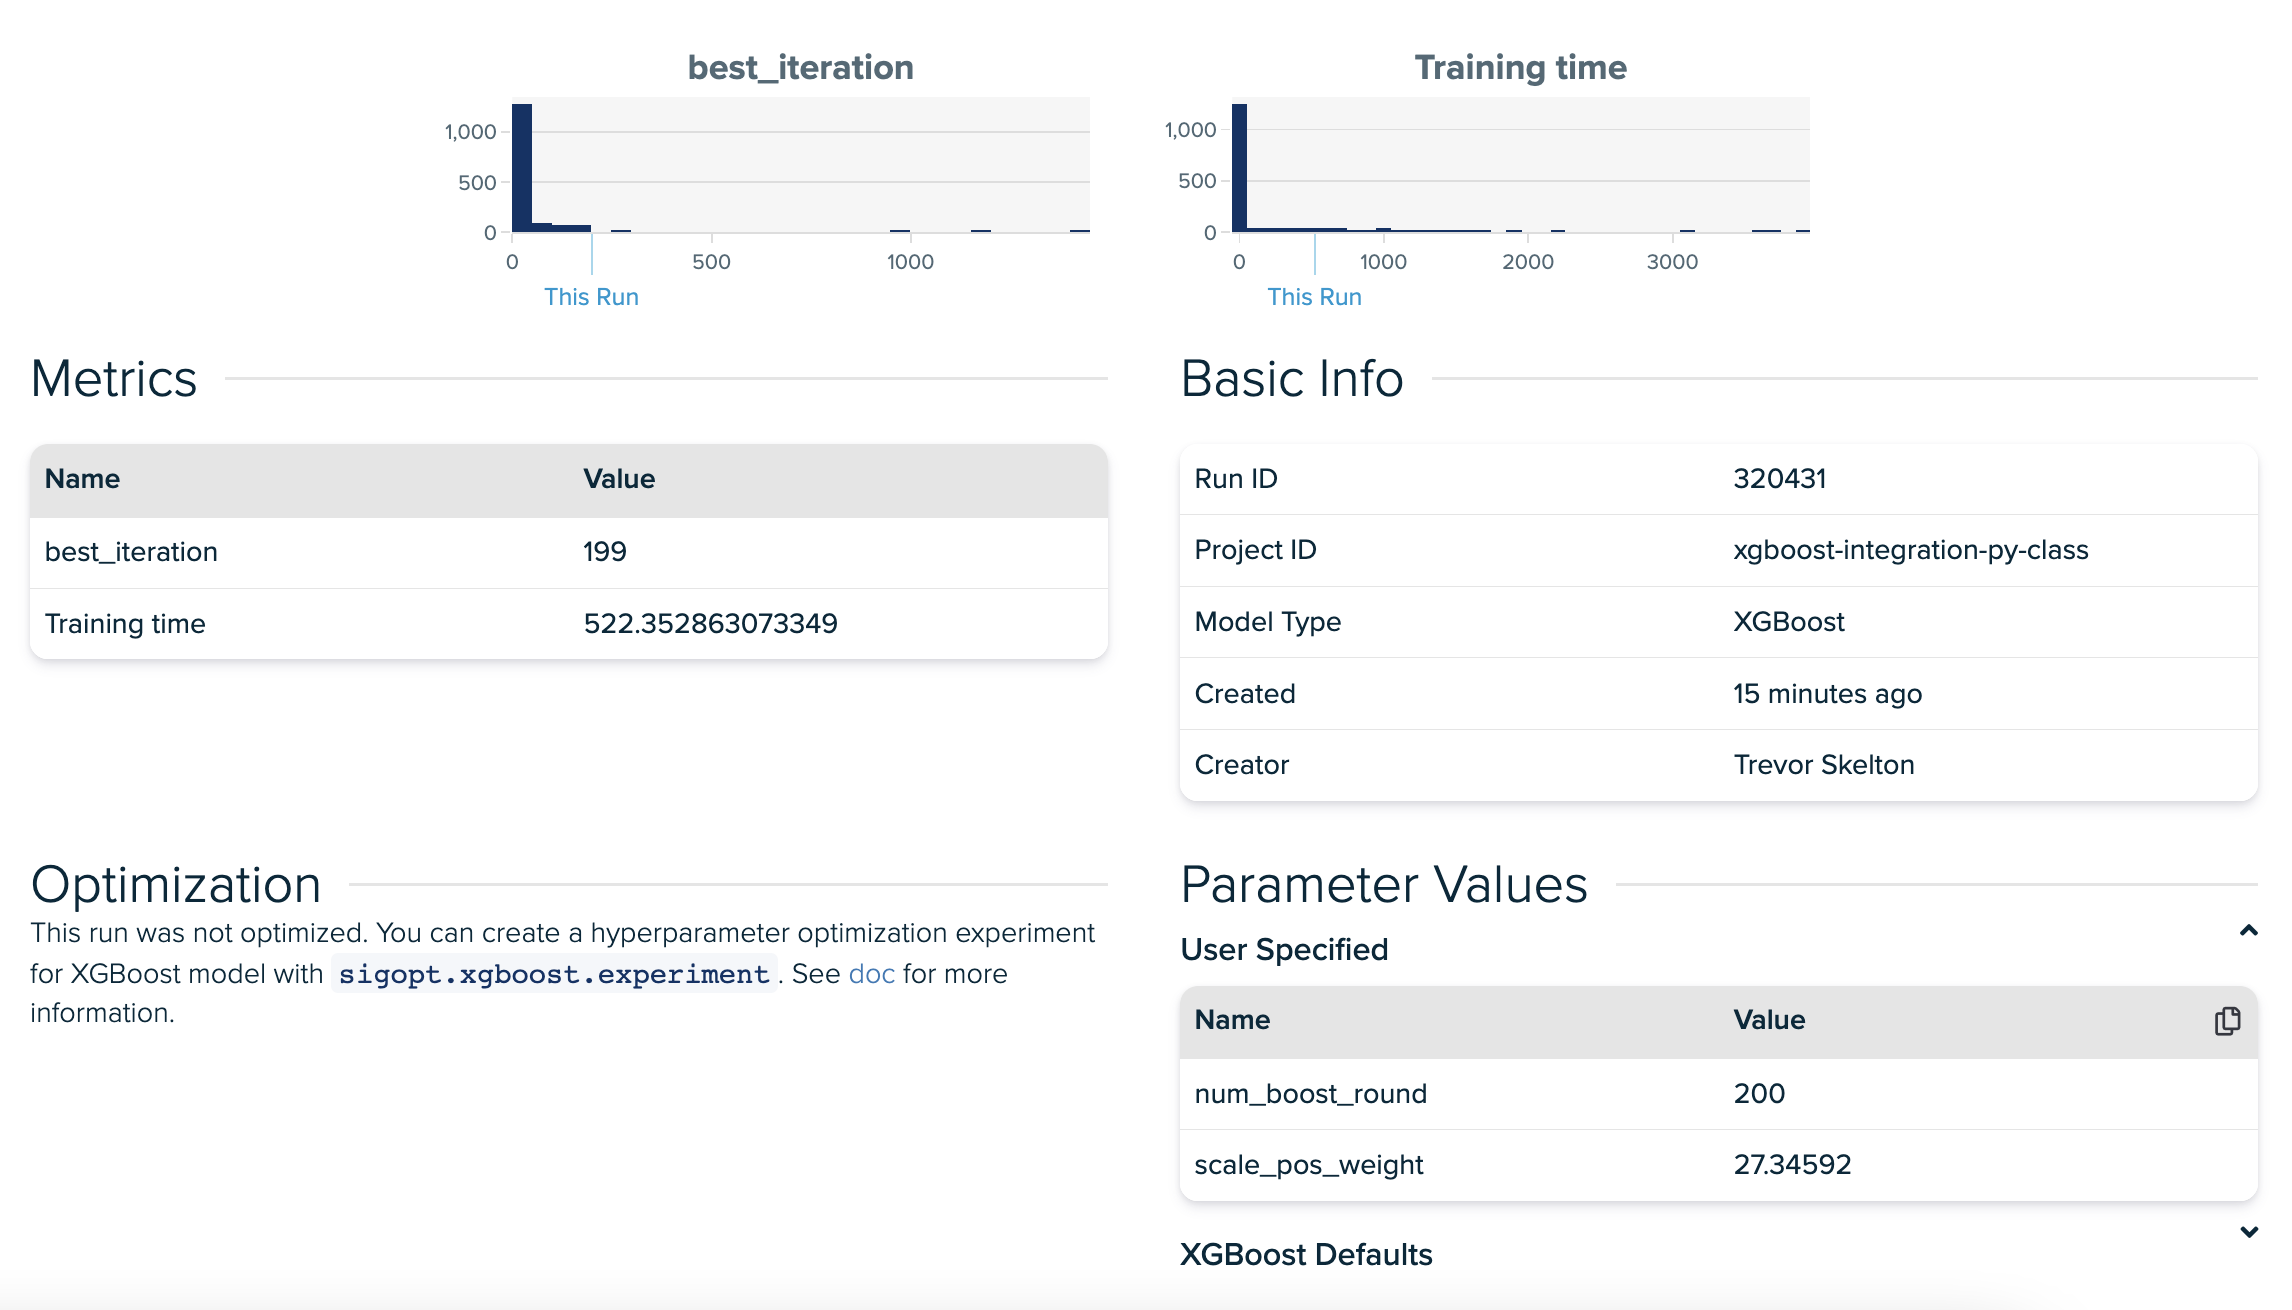

After the XGBoost model is trained, SigOpt evaluates the model's performance with a few common metrics on the provided `evals` datasets (the test set in our case) and lists the results under **Metrics**. We can also clearly see this run's hyperparameters used in the **Parameter Values** section, which match the static values we provided, while the rest are listed as "XGBoost Defaults" which could be expanded to see the detail by clicking the arrow.

SigOpt also provides a bar chart with the relative feature importances XGBoost calculated during the run, which can be very helpful insight for analysis or feature engineering.

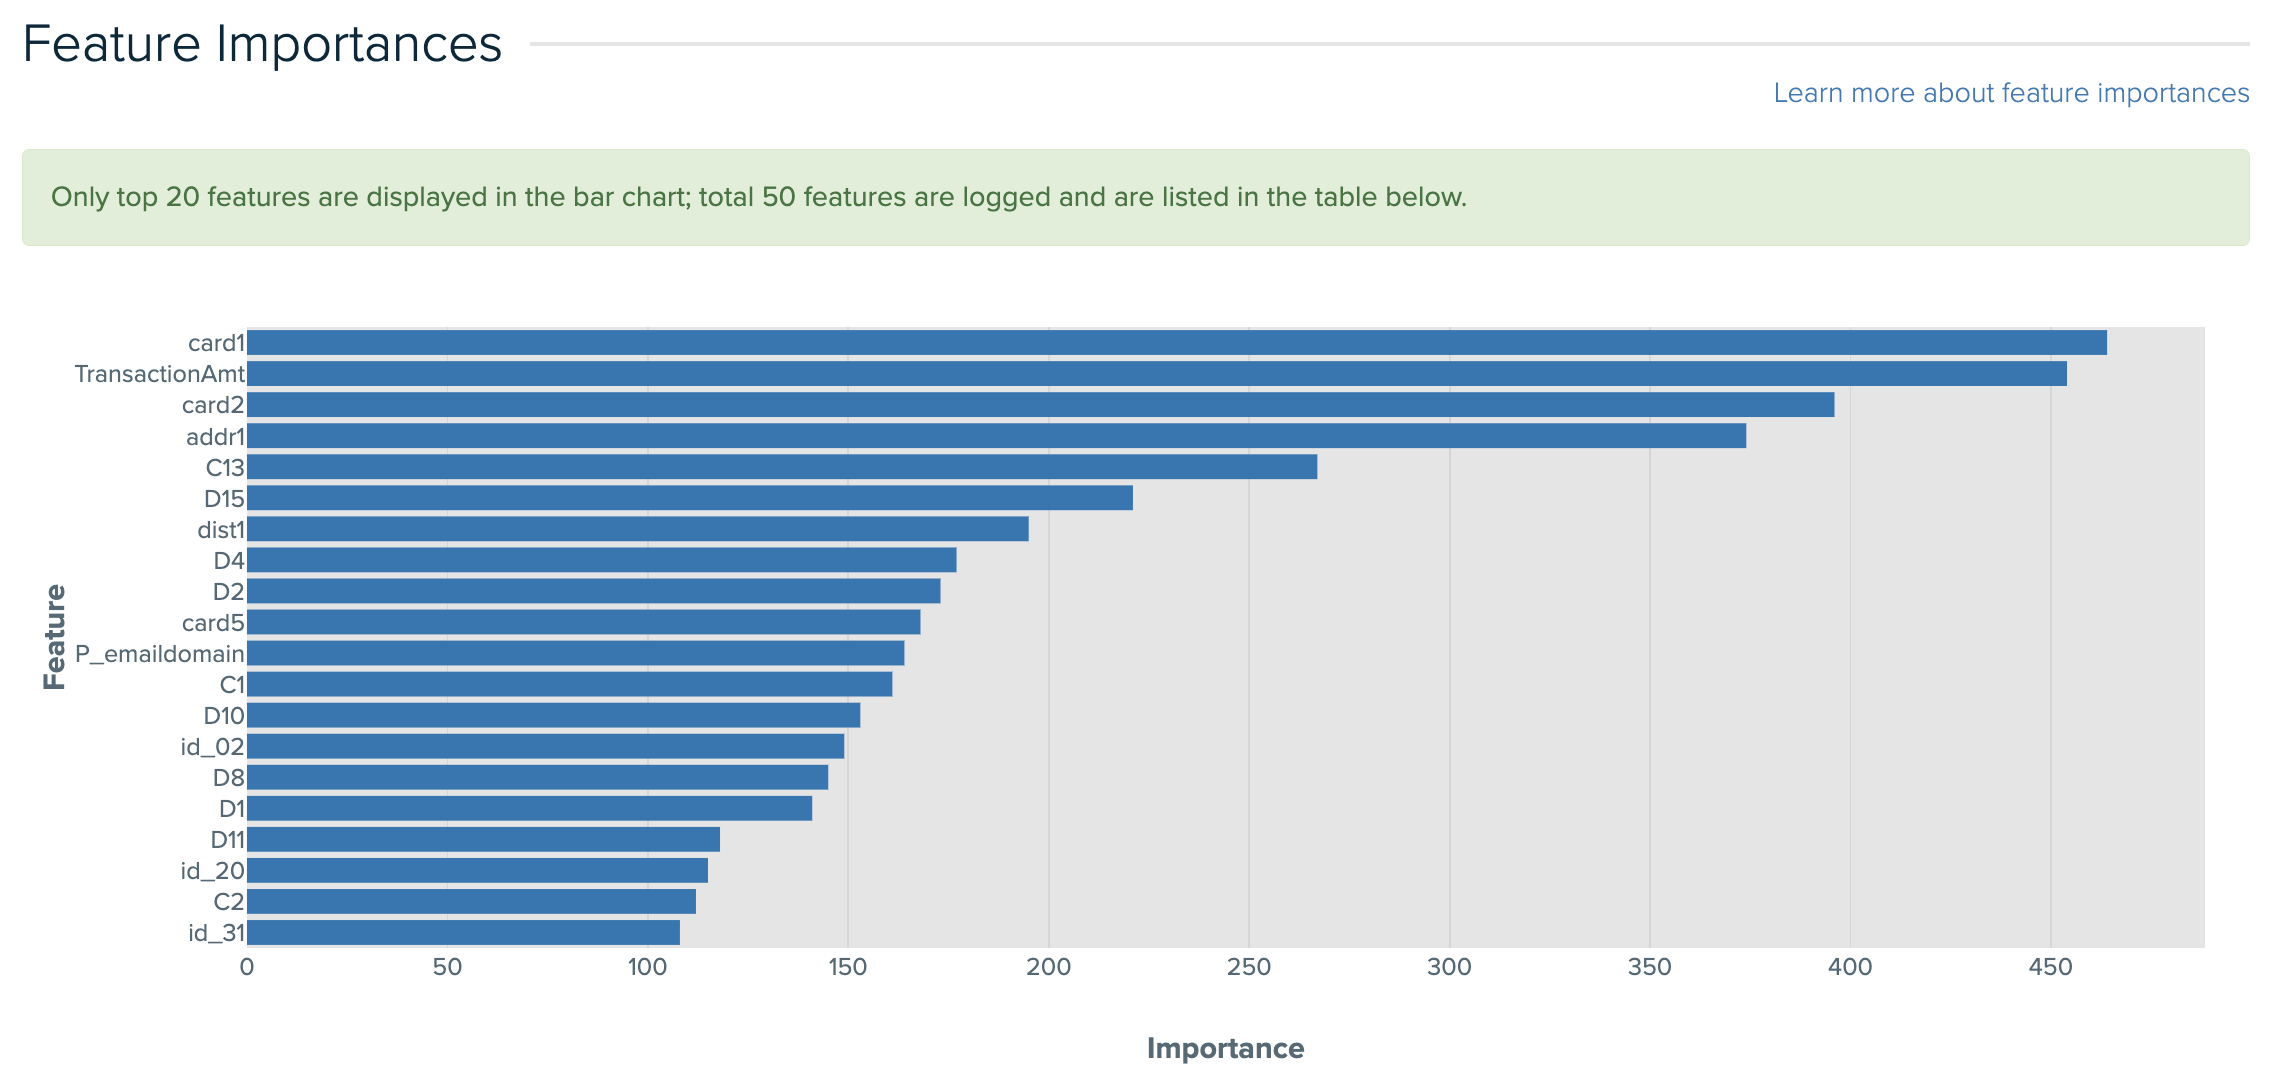

It makes sense that the transaction amount, and details about the credit card in use are highly important when determining if the transaction is fraudulent.

## Train and Tune SigOpt Model
In production and deployment of machine learning models, we seek to maximize our models' performance. SigOpt's experiment API allows for efficient, intelligent experimentation that will provide suggested hyperparameter values to enhance our models' performance with only a few lines of code. On top of this, using the XGBoost integration, we can take advantage of SigOpt's intelligent, automated hyperparameter selection. Often you need specialized expertise and techniques to find optimized hyperparameters, or even just to select the list of hyperparameters and bounds for other optimization packages. This integration removes this burden from the user, making high-performing XGBoost models much more accessible.

This is possible through extensive work by SigOpt's research team. The following violin plot shows the distribution of the importance scores measured by functional analysis of variance (FANOVA) over a suite of different learning problems and over 10,000 hyperparameter configurations of XGBoost, the results of which are used to inform the optimizer. Of course these orderings are not objective; they depend on the problem, optimization metric, etc. However, they form a reasonable foundation for SigOpt's optimizer in this integration. This is a small snippet of the results of the research into XGBoost that will be discussed further in the future.

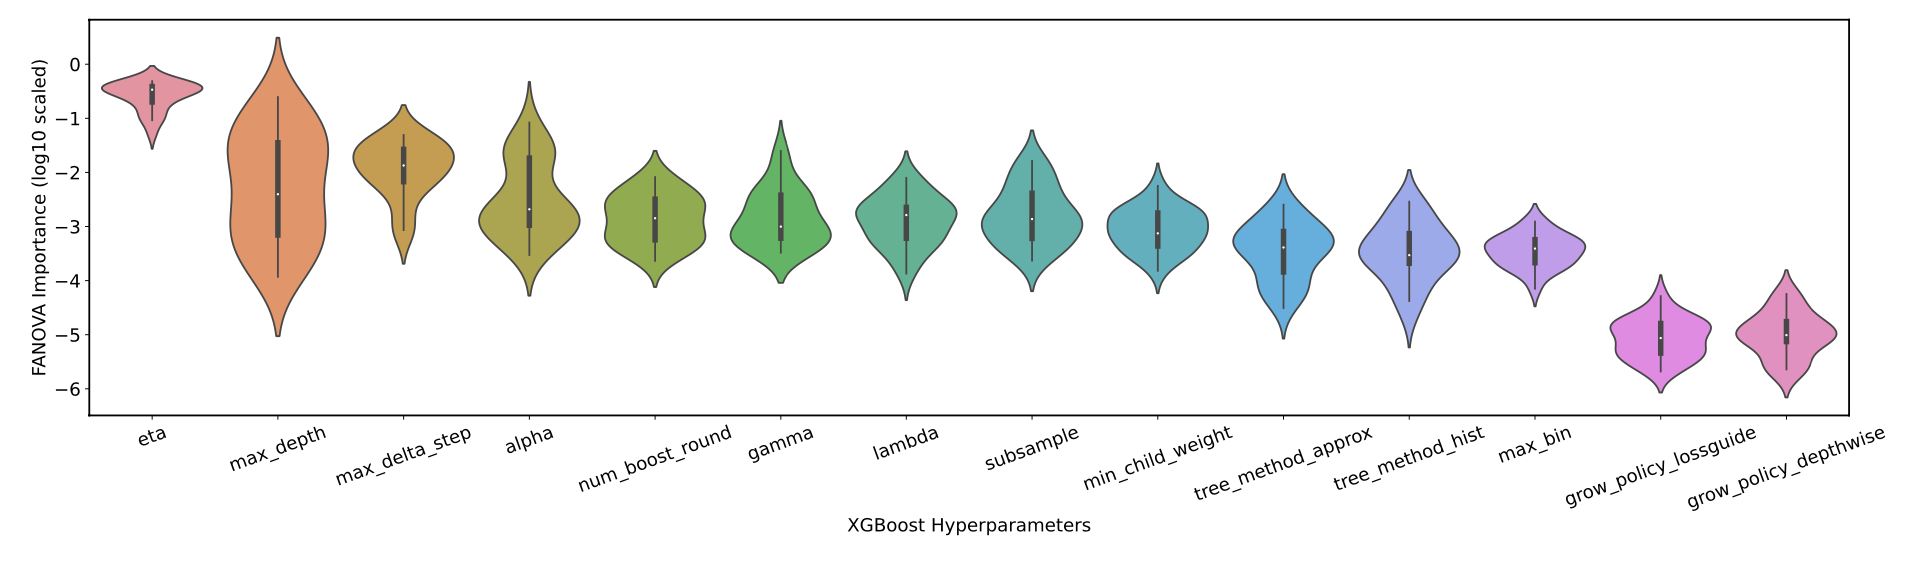

We'll first set the configuration for the experiment we will run. This includes the experiment name, metrics, and observation budget, or maximum number of runs SigOpt will perform. While we have the option to provide hyperparameter lists and bounds for the optimizer, in this example we'll omit these entirely and let the integration intelligently optimize the most important hyperparameters for us in an efficient manner. We therefore expect in our runs that the hyperparameters with most importance on the above plot such as `eta` (learning rate), `max_depth`, `alpha`, `num_boost_round`, and `gamma` to be of more focus for the SigOpt optimizer.

Given the nature of this fraud detection problem, we'll set the optimization metric to be the F1 score to balance between precision and recall. Finally, we set our observation budget to 20 runs, which means we'll train 20 different models for SigOpt to optimize. Feel free to lower this for faster optimization at the cost of some performance, or increase this if you determine SigOpt can further optimize. Generally for SigOpt a ballpark recommendation is to set a minimum of `10 * d` runs for quality hyperparameter suggestions, where `d` is the number of parameters to optimize, but the XGBoost integration is able to provide better quality recommendations in fewer runs on average, so 20 works here.

Our experiment configuration is set up simply with the following code block:

In [14]:
my_config = dict(
    name="XGBoost Fraud Detection Experiment",
    metrics=[
        dict(name="F1", strategy="optimize", objective="maximize")],
    budget=20,
)

We run an experiment by passing in the configuration and the matrices as seen below. SigOpt will optimize the hyperparameters against the performance on the validation set.

Here we also set a number of XGBoost model parameters to hold static for all experiment runs. This includes the objective (logistic for this classification task), the weight for the positive examples we calculated earlier (to correct for class imbalance), and verbosity to 0 to silence warnings being output to the notebook.

The below code block may take some time depending on your system, given the size of this dataset (~3 hours on a 4 core i5).

In [15]:
%%time
experiment = sigopt.xgboost.experiment(
    experiment_config=my_config,
    dtrain=dtrain,
    evals=[(dval, "val_set")],
    # XGB parameters to be fixed for all runs:
    params = {"scale_pos_weight":pos_weight, "objective":"binary:logistic", "verbosity":0}, 
)

Experiment created, view it on the SigOpt dashboard at https://app.sigopt.com/experiment/523350
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320096
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320096
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320106
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320106
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320115
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320115
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320170
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320170
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320204
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320204
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/3202

After the above code block finishes, check the results of the experiment on your SigOpt [dashboard](https://app.sigopt.com/experiments), or dive into our experiment results [here](https://app.sigopt.com/guest?guest_token=YJJYFVXLSRSZPNVYILFYUJKGWXWWLFBJYXFKOFTXYMXCGKZB) with a guest session. Explore the plots accessible for all SigOpt experiments, including experiment histories for the variation of each hyperparameter, parallel coordinates between hyperparameters, and the hyperparameter values for the best run. With enough runs, SigOpt provides a chart of relative hyperparameter importance for the performance metric chosen. Under the History tab, you can also dive into any of the individual runs to check the Feature Importances or other metrics calculated for any particular training/optimization run.

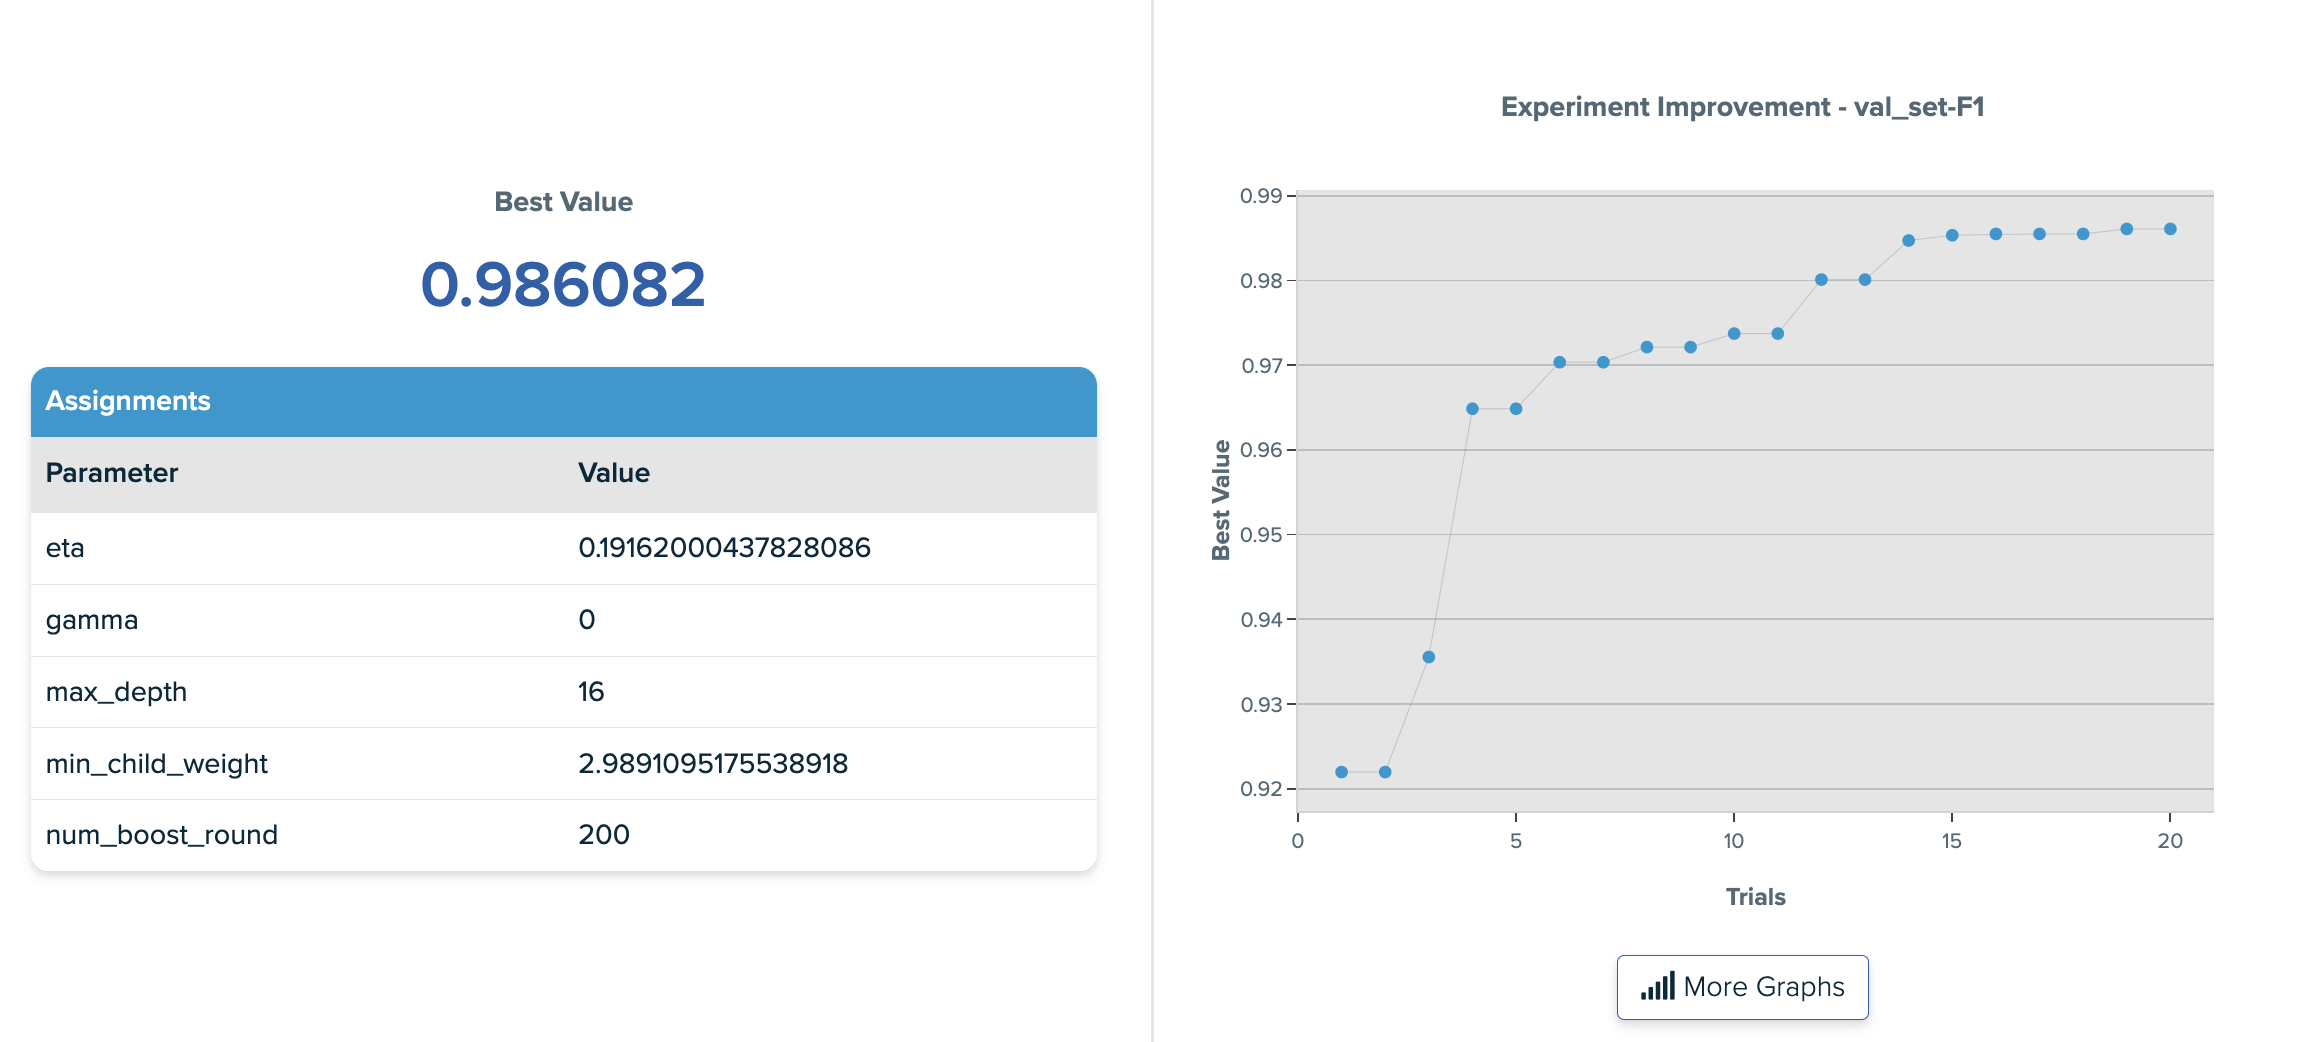

Compared with the default hyperparameter values used in the baseline model, the SigOpt tuned model uses a smaller learning rate, a higher `gamma` to regularize through pruning, and a larger max depth for more nuanced trees. The deeper trees are likely needed given the high number of features in our data, while still serving as weak learners for boosting. The better regularization will hopefully allow the tuned model to generalize better on unseen data, even though each individual tree can grow deeper.

## Evaluate on Test Set

Finally, we'll evaluate the baseline and SigOpt-tuned XGBoost models against the holdout test set to see how well they perform on data neither model has seen.


First, we'll take the hyperparameters from the best SigOpt training run during our experimentation and train a model with the training set. We can use `experiment.get_best_runs()` to return an iterator of the best runs, then take the `assignments` from the best run to use the hyperparameters used in SigOpt's best performing run. We also use the best assignments to retrieve the number of boosting rounds and early stopping rounds used for the best SigOpt run, and provide these as arguments to `sigopt.xgboost.run`.

In [16]:
%%time
for run in experiment.get_best_runs():
    sigopt_params = dict(run.assignments) #obtain best SigOpt run's parameter values

sigopt_params['objective'] = 'binary:logistic' #specify the objective instead of allowing SigOpt to choose
sigopt_run_options = { 'name':'SigOpt Optimized XGBoost Fraud Classifier' }
sigopt_fraud = sigopt.xgboost.run(sigopt_params,
                             dtrain,
                             num_boost_round=sigopt_params['num_boost_round'],
                             early_stopping_rounds=sigopt_params['early_stopping_rounds'],
                             evals=[(dval,'val_set')],
                             run_options=sigopt_run_options)
sigopt_model = sigopt_fraud.model
print(f"View run at https://app.sigopt.com/run/{sigopt_fraud.run.id}")

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320412
[0]	val_set-logloss:0.58352
[1]	val_set-logloss:0.50285
[2]	val_set-logloss:0.44231
[3]	val_set-logloss:0.39416
[4]	val_set-logloss:0.35599
[5]	val_set-logloss:0.32308
[6]	val_set-logloss:0.29579
[7]	val_set-logloss:0.27313
[8]	val_set-logloss:0.24864
[9]	val_set-logloss:0.22922
[10]	val_set-logloss:0.21444
[11]	val_set-logloss:0.20227
[12]	val_set-logloss:0.19262
[13]	val_set-logloss:0.18227
[14]	val_set-logloss:0.17399
[15]	val_set-logloss:0.16703
[16]	val_set-logloss:0.16231
[17]	val_set-logloss:0.15428
[18]	val_set-logloss:0.15082
[19]	val_set-logloss:0.14536
[20]	val_set-logloss:0.14258
[21]	val_set-logloss:0.13914
[22]	val_set-logloss:0.13435
[23]	val_set-logloss:0.13120
[24]	val_set-logloss:0.12834
[25]	val_set-logloss:0.12550
[26]	val_set-logloss:0.12281
[27]	val_set-logloss:0.12101
[28]	val_set-logloss:0.11974
[29]	val_set-logloss:0.11777
[30]	val_set-logloss:0.11450
[31]	val_set-logloss:0.11263


Now we can compare the baseline model versus the model tuned with SigOpt's XGBoost integration.

In [25]:
baseline_probs = baseline_model.predict(dtest)
baseline_preds = (baseline_probs > 0.5).astype(int) #convert probabilities to class labels

sigopt_probs = sigopt_model.predict(dtest)
sigopt_preds = (sigopt_probs > 0.5).astype(int) #convert probabilities to class labels

baseline_f1 = f1_score(y_test, baseline_preds)
sigopt_f1 = f1_score(y_test, sigopt_preds)

print(f'Baseline Test Set F1 Score: {baseline_f1}\nSigOpt Test Set F1 Score: {sigopt_f1}')

Baseline Test Set F1 Score: 0.5159447146938462
SigOpt Test Set F1 Score: 0.7789502164502164


With an identical model architecture, using SigOpt's XGBoost integration with intelligent selection and tuning of hyperparameters alone gives a noticeable boost in model performance on unseen data, while training significantly faster as well. The CPU time to achieve these results is also relatively low, especially compared to alternatives to find well-performing hyperparameters like grid search or trial and error.

## Wrapping Up
Here we've demonstrated the power of SigOpt and the XGBoost integration in a relatively quick and simple classification machine learning problem. Using SigOpt's XGBoost Integration allows for expert-level optimization without expert-level knowledge of XGBoost, and allows fast and efficient hyperparameter experimentation with a simple and easy API.

Now it's time to try your hand at modeling! Can you do better on this dataset with more SigOpt runs, architecture improvements, feature engineering, or other optimization?

Please feel free to send us feedback on your experience with the XGBoost Integration at the [SigOpt Community](https://community.sigopt.com/). You can sign up for SigOpt for free at https://sigopt.com/signup.

Want to learn more? Explore:
* [Tracking XGBoost Training](https://docs.sigopt.com/xgboost/xgboost_run)
* [Tuning XGBoost Models](https://docs.sigopt.com/xgboost/xgboost_experiment)
* [Live Now! New XGBoost Integration](https://sigopt.com/blog/live-now-new-xgboost-integration/)
* [SigOpt Experiment Results](https://app.sigopt.com/guest?guest_token=YJJYFVXLSRSZPNVYILFYUJKGWXWWLFBJYXFKOFTXYMXCGKZB) for this code
* [Sign up for free!](https://sigopt.com/signup)